In [1]:
%matplotlib inline
from pylab import *
# import cv2
import rasterio as rio

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

import rasterio

# add the unet helpers
sys.path.append('../')
from test_unet_helpers import *

# torch stuff
import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models, datasets
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable

C:\software\anaconda3\envs\eapy_gbdx\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\software\anaconda3\envs\eapy_gbdx\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\software\anaconda3\envs\eapy_gbdx\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\software\anaconda3\envs\eapy_gbdx\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\software\anaconda3\envs\eapy_gbdx\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc si

In [34]:
train_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_256x256\train'
test_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_256x256\test'
val_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_256x256\val'

In [14]:
from glob import glob 

class DG_GT_Dataset(Dataset):
    """Dataset class for ignition types (Y var)"""
    
    def __init__(self, data_dir, img_transform=None, gt_transform=None):
        """ 
        Args:
            data_dir(string): the folder containing the image files
            transform (callable, optional): Optional transform to  be applied to image data
            ig_types (iterable, optional): types of ignition rasters to include
            x_var (iterable, optional): list of predictor variable names
            land_mask (string, optional): defines whether or not to return land mask
        """
        
        # some sanity checks
        assert os.path.exists(data_dir)
        
        self.img_files = glob(data_dir + '/dg*.tif')
        self.gt_files = glob(data_dir + '/gt*.tif')
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        
        assert len(self.img_files) == len(self.gt_files)
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <var_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        img_file = self.img_files[idx]
        gt_file = self.gt_files[idx]
        
        with rio.open(img_file) as src:
            img_arr = src.read()
            
        with rio.open(gt_file) as src:
            gt_arr = src.read()

        if (self.img_transform is not None):
            return (self.img_transform(torch.from_numpy(img_arr)), 
                    self.gt_transform(torch.from_numpy(gt_arr)))   
        else:
            return (torch.from_numpy(img_arr), torch.from_numpy(gt_arr)) # return X, Y, Mask (Mask uses LandMask in X-var folder)
        
        
    def __len__(self):
        return len(self.img_files)

In [39]:
train_ds = DG_GT_Dataset(train_folder)
test_ds = DG_GT_Dataset(test_folder)
val_ds = DG_GT_Dataset(val_folder)

In [41]:
train_ds[0][1].shape, test_ds[0][1].shape, val_ds[0][1].shape, \
train_ds[0][0].shape, test_ds[0][0].shape, val_ds[0][0].shape

(torch.Size([1, 256, 256]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 256, 256]),
 torch.Size([8, 256, 256]),
 torch.Size([8, 256, 256]),
 torch.Size([8, 256, 256]))

In [43]:
means = []
for i in range(600):
    means.append(train_ds[i][0].mean())    

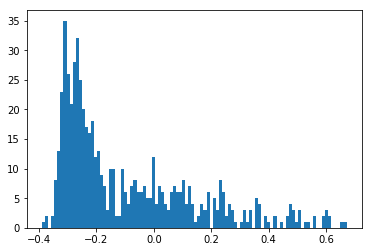

In [44]:
plt.hist(means, bins=100)
plt.show()

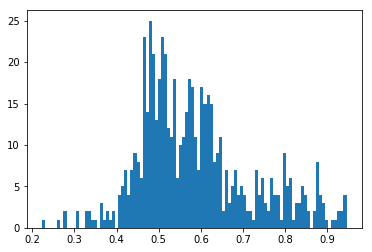

In [47]:
means = []
for i in range(600):
    means.append(train_ds[i][1].numpy().astype('float').mean()) 

plt.hist(means, bins=100)
plt.show()